In [113]:
# Run this code if you get errors with missing requirements
import sys
!{sys.executable} -m pip install mysql-connector

import pandas as pd
import mysql.connector

mydb = mysql.connector.connect(
  host="iiwari-mariadb-server",
  user="root",
  passwd="d41k4Duu",
  database="iiwari_org"
)


# Leikataan X arvoa hieman enemmä että latausasemat ei vaikuta ruuhkaan

In [114]:
mycursor = mydb.cursor(dictionary=True)
mycursor.execute("SELECT node_id, timestamp, x, y FROM SensorData WHERE timestamp > '2019-05-24 06:00:08.078133+00:00' AND timestamp < '2019-05-24 23:00:08.078133+00:00'  AND x > 1200  AND X < 10406 AND y < 5220 AND y > 0 AND   q <100 AND z = 0");
database = pd.DataFrame(mycursor.fetchall())
print(database)

       node_id                            timestamp     x     y
0        51889    b'2019-05-24 06:09:01.9878+00:00'  1206  2758
1        51889  b'2019-05-24 06:09:02.990417+00:00'  1266  2762
2        51889  b'2019-05-24 06:09:03.991372+00:00'  1502  2777
3        51889  b'2019-05-24 06:09:03.991378+00:00'  1502  2777
4        51889  b'2019-05-24 06:09:04.989675+00:00'  1705  2782
...        ...                                  ...   ...   ...
27135    51976  b'2019-05-24 17:45:33.987279+00:00'  1314   990
27136    51976  b'2019-05-24 17:45:34.986704+00:00'  1277   975
27137    51976  b'2019-05-24 17:45:34.986739+00:00'  1277   975
27138    51976  b'2019-05-24 17:45:35.987003+00:00'  1234   970
27139    51976  b'2019-05-24 17:45:35.987006+00:00'  1234   970

[27140 rows x 4 columns]


# Tehdään uusi taulu ja laitetaan sinne node_id.

In [115]:

nodes = pd.DataFrame()

nodes['node_id'] = database['node_id']

print(nodes)


       node_id
0        51889
1        51889
2        51889
3        51889
4        51889
...        ...
27135    51976
27136    51976
27137    51976
27138    51976
27139    51976

[27140 rows x 1 columns]


# Laitetaan timestamppi tauluun ja poistetaan siitä turhat

In [116]:
nodes['timestamp'] = database['timestamp'].astype(str)
nodes['timestamp'] = nodes['timestamp'].str.slice(2, -7)
print(nodes)

       node_id                   timestamp
0        51889    2019-05-24 06:09:01.9878
1        51889  2019-05-24 06:09:02.990417
2        51889  2019-05-24 06:09:03.991372
3        51889  2019-05-24 06:09:03.991378
4        51889  2019-05-24 06:09:04.989675
...        ...                         ...
27135    51976  2019-05-24 17:45:33.987279
27136    51976  2019-05-24 17:45:34.986704
27137    51976  2019-05-24 17:45:34.986739
27138    51976  2019-05-24 17:45:35.987003
27139    51976  2019-05-24 17:45:35.987006

[27140 rows x 2 columns]


# Muutetaan timestamp datetime64 muotoon ja pyörristetään tunnin tarkkuudelle

In [117]:
nodes['timestamp'] = nodes['timestamp'].astype('datetime64[ns]')
nodes['timestamp'] = pd.Series(nodes['timestamp']).dt.round("H")
print(nodes)

       node_id           timestamp
0        51889 2019-05-24 06:00:00
1        51889 2019-05-24 06:00:00
2        51889 2019-05-24 06:00:00
3        51889 2019-05-24 06:00:00
4        51889 2019-05-24 06:00:00
...        ...                 ...
27135    51976 2019-05-24 18:00:00
27136    51976 2019-05-24 18:00:00
27137    51976 2019-05-24 18:00:00
27138    51976 2019-05-24 18:00:00
27139    51976 2019-05-24 18:00:00

[27140 rows x 2 columns]


# Tehdään timestampeista indexejä ja poistetaan entinen timestamp 


In [118]:
nodes.index = nodes['timestamp']

nodes = nodes.drop('timestamp', axis=1)
print(nodes)


                     node_id
timestamp                   
2019-05-24 06:00:00    51889
2019-05-24 06:00:00    51889
2019-05-24 06:00:00    51889
2019-05-24 06:00:00    51889
2019-05-24 06:00:00    51889
...                      ...
2019-05-24 18:00:00    51976
2019-05-24 18:00:00    51976
2019-05-24 18:00:00    51976
2019-05-24 18:00:00    51976
2019-05-24 18:00:00    51976

[27140 rows x 1 columns]


# Lasketaan kaikki samat tuntimäärät yhteen

In [119]:
nodes = nodes.resample('H').count()
print(nodes)

                     node_id
timestamp                   
2019-05-24 06:00:00     1491
2019-05-24 07:00:00      972
2019-05-24 08:00:00      777
2019-05-24 09:00:00      683
2019-05-24 10:00:00     2066
2019-05-24 11:00:00     1631
2019-05-24 12:00:00      131
2019-05-24 13:00:00     2557
2019-05-24 14:00:00     1446
2019-05-24 15:00:00     2084
2019-05-24 16:00:00     6337
2019-05-24 17:00:00     5722
2019-05-24 18:00:00     1243


# Tehdään 'esiintyvyysprosentti' dataframeen

In [120]:
nodes['esintyvyysprosentti'] = 100 * (nodes['node_id'] / nodes['node_id'].sum())
print(nodes)


                     node_id  esintyvyysprosentti
timestamp                                        
2019-05-24 06:00:00     1491             5.493736
2019-05-24 07:00:00      972             3.581430
2019-05-24 08:00:00      777             2.862933
2019-05-24 09:00:00      683             2.516581
2019-05-24 10:00:00     2066             7.612380
2019-05-24 11:00:00     1631             6.009580
2019-05-24 12:00:00      131             0.482682
2019-05-24 13:00:00     2557             9.421518
2019-05-24 14:00:00     1446             5.327929
2019-05-24 15:00:00     2084             7.678703
2019-05-24 16:00:00     6337            23.349300
2019-05-24 17:00:00     5722            21.083272
2019-05-24 18:00:00     1243             4.579956


# Poistetaan vuodet, kuukaudet ja päivät index-timestampista, lisätään se otsikkoon seuraavassa vaiheessa

In [121]:
nodes.index = nodes.index.astype(str)
nodes.index = nodes.index.str.slice(10, -6)
print(nodes)

           node_id  esintyvyysprosentti
timestamp                              
 06           1491             5.493736
 07            972             3.581430
 08            777             2.862933
 09            683             2.516581
 10           2066             7.612380
 11           1631             6.009580
 12            131             0.482682
 13           2557             9.421518
 14           1446             5.327929
 15           2084             7.678703
 16           6337            23.349300
 17           5722            21.083272
 18           1243             4.579956


# Plotataan kärryjen prosenttiosuus päivästä tunnettain

Text(0.5, 0, 'Kellonaika')

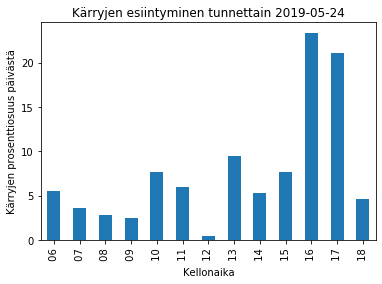

In [122]:
import pylab as plt

nodes.groupby("timestamp").esintyvyysprosentti.mean().plot.bar(title='Kärryjen esiintyminen tunnettain 2019-05-24')
plt.ylabel('Kärryjen prosenttiosuus päivästä')
plt.xlabel('Kellonaika')
